# This notebook contains:
* Diurnal cycle plots of BARRA-2 surface winds vs station data for different regimes
* Barb and diurnal cycle plots of wind direction and speed barra vs station + function for circmean wind direction calculation

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
import os
import glob
from datetime import datetime
import seaborn as sns
from metpy.units import units
from shapely import Polygon
import geopandas as gpd
from scipy.stats import circmean
from sklearn.metrics import mean_squared_error
import pytz
from datetime import datetime, timedelta, time
import dask.dataframe as dd
import dask.distributed
import matplotlib.gridspec as gridspec
import windrose
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm

In [2]:
def UTC_to_LST(ds, timezone): # longitude
    ds = ds.copy()
    # Convert to pandas datetime in UTC
    time_objects_utc = pd.to_datetime(ds['time'].values).tz_localize('UTC')
    
    # Convert to local standard time using pytz
    local_timezone = pytz.timezone(timezone)
    time_objects_local = time_objects_utc.tz_convert(local_timezone).tz_localize(None)
    
    # Calculate longitude offset (in hours)
    # longitude_offset = timedelta(minutes=longitude*12/180) # /15)
    
    # # Local Solar Time = Local Standard Time + longitude offset
    # time_objects_solar = time_objects_local + longitude_offset
    
    # Assign back to ds['time'], remove timezone info if desired:
    ds['time'] = time_objects_local#.tz_localize(None)
    return ds

In [3]:
def lst(ds,longitude,timezone):
    """
    Calculate Local Solar Time (LST) based on longitude and timezone.
    """
    ds = ds.copy()
    # Convert to pandas datetime in UTC
    time_objects_utc = pd.to_datetime(ds['time'].values).tz_localize('UTC')
    
    # Convert to local standard time using pytz
    local_timezone = pytz.timezone(timezone)
    time_objects_local = time_objects_utc.tz_convert(local_timezone).tz_localize(None)

    # Calculate the day of the year
    doy = ds['time'].dt.dayofyear
    
    # Calculate the Equation of Time (EoT)
    b = 360 * (doy - 81) / 365          # b is a factor based on the day of the year
    EoT_minutes = 9.87 * np.sin(2 * np.radians(b)) - 7.67 * np.sin(np.radians(b + 78.7))
    
    # Calculate LST in hours 
    time_offset = EoT_minutes + 4*longitude
    print(time_offset)
    tst = ds['time'].dt.hour*60 + ds['time'].dt.minute + ds['time'].dt.second/60 + time_offset
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst)
    # tst = utc_time + time_offset
    ds['time'] = solar_time
    return 

In [4]:
def lst(ds, longitude, timezone):
    """
    Calculate Local Solar Time (LST) for each time entry in the dataset.

    Parameters:
    - ds: xarray.Dataset with a 'time' coordinate in UTC
    - longitude: float, degrees east
    - timezone: string, e.g. 'Australia/Melbourne'

    Returns:
    - xarray.Dataset with new 'local_solar_time' coordinate (naive datetime)
    """

    ds = ds.copy()

    # Ensure time is in datetime64[ns] with UTC timezone
    time_utc = pd.to_datetime(ds['time'].values).tz_localize('UTC')
    
    # Convert to local standard time (without timezone info)
    local_time = time_utc.tz_convert(timezone).tz_localize(None)
    
    # Day of year
    doy = pd.Series(local_time).dt.dayofyear.values

    # Equation of Time (in minutes)
    b = 360 * (doy - 81) / 365
    EoT = 9.87 * np.sin(2 * np.radians(b)) - 7.67 * np.sin(np.radians(b + 78.7))

    # Get standard meridian for timezone
    standard_offset = pytz.timezone(timezone).utcoffset(time_utc[0]).total_seconds() / 3600
    standard_meridian = 15 * standard_offset

    # Time correction (in minutes)
    time_correction = EoT + 4 * (longitude - standard_meridian)

    # Apply correction to local time
    lst_values = local_time + pd.to_timedelta(time_correction, unit='m')

    # Add as a new coordinate or variable
    ds = ds.assign_coords(local_solar_time=("time", lst_values))

    return ds

In [5]:
fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# station ID's can be found on the BoM website: http://www.bom.gov.au/catalogue/observations/about-weather-observations.shtml#maps
ds_stations = xr.open_dataset(fp, engine="h5netcdf")
ds_LST = UTC_to_LST(ds_stations,'Australia/Sydney')
jfma_data = ds_LST.sel(time=ds_LST.time.dt.month.isin([1,2,3,4]))

# cairns ID = 31011 --> station=21; townsville ID = 32040 --> station=30
ds_cairns_wd = jfma_data["wdir"].sel(station=21)* units("degrees")
ds_cairns_ws = jfma_data["wspd"].sel(station=21)* (1000/(60*60)) *  units("m/s")
ds_towns_wd = jfma_data["wdir"].sel(station=30)* units("degrees")
ds_towns_ws = jfma_data["wspd"].sel(station=30)* (1000/(60*60)) *  units("m/s")

In [6]:
def wind_masks(ds_wdir,ds_wdspd):
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask

In [7]:
def calc_circ_mean_wd(ds, **kwargs):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit', **kwargs)
    return np.rad2deg(circmean_ds)

In [8]:
cairns_wd_mask, cairns_ws_masked = wind_masks(ds_cairns_wd,ds_cairns_ws)
towns_wd_mask, towns_ws_masked = wind_masks(ds_towns_wd,ds_towns_ws)

In [9]:
# hourly averages
cairns_wd = cairns_wd_mask.groupby('time.hour').reduce(calc_circ_mean_wd)
cairns_ws = cairns_ws_masked.groupby('time.hour').mean('time')
towns_wd = towns_wd_mask.groupby('time.hour').reduce(calc_circ_mean_wd)
towns_ws = towns_ws_masked.groupby('time.hour').mean('time')

In [20]:
# Open and regrid ETOPO2V2 dataset
NOAA_ETOPO2V2_ds = xr.open_dataset('/home/563/ac9768/GBR/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
NOAA_ETOPO2V2_ds_slice = NOAA_ETOPO2V2_ds.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(NOAA_ETOPO2V2_ds_slice['x'].data), max(NOAA_ETOPO2V2_ds_slice['x'].data), len(NOAA_ETOPO2V2_ds_slice['x'].data))
lat = np.linspace(min(NOAA_ETOPO2V2_ds_slice['y'].data), max(NOAA_ETOPO2V2_ds_slice['y'].data), len(NOAA_ETOPO2V2_ds_slice['y'].data))
lon, lat = np.meshgrid(lon, lat)
topo = NOAA_ETOPO2V2_ds_slice['z'].data

In [24]:
def plot_windrose_map(cairns_wd,cairns_ws,towns_wd,towns_ws,main_ax, hour, letterlabel, cbar: bool=None,legend: bool=None):
    proj = ccrs.PlateCarree()
    main_ax.set_extent([144, 149, -21.5, -14], crs=proj)
    main_ax.coastlines()

    cairns_wd_hour = cairns_wd.sel(time=cairns_wd.time.dt.hour.isin(hour))
    cairns_ws_hour = cairns_ws.sel(time=cairns_ws.time.dt.hour.isin(hour))
    towns_wd_hour = towns_wd.sel(time=towns_wd.time.dt.hour.isin(hour))
    towns_ws_hour = towns_ws.sel(time=towns_ws.time.dt.hour.isin(hour))

    fig = main_ax.figure
    sns.set_style('white')
    color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fcb9','#d9f0a3','#addd8e',
            '#78c679','#31a354','#006837','darkslategrey','#d7ccca']
    levels = [-800, -500, -300, -200, -100, -50, -25, 0, 50, 100, 200, 300, 500, 800, 1000]
    cs = main_ax.contourf(lon,lat,topo,levels=levels,extend="both",colors=color,alpha=0.75)
    if cbar:
        cbar_ax = fig.add_axes([0.9, 0.58, 0.02, 0.3]) #([left, bottom, width, height])
        cb = fig.colorbar(cs, cax=cbar_ax)
        cb.set_label("Meters",fontsize=15)

    # Coordinates of the station we were measuring windspeed
    towns_lon, towns_lat = (146.77,-19.25)
    cairns_lon, cairns_lat = (145.75,-16.87)

    size = 2
    # Inset axes with a fixed size
    wrax_towns = inset_axes(
        main_ax,
        width=size,  # size in inches
        height=size,  # size in inches
        loc="center",  # center bbox at given position
        bbox_to_anchor=(towns_lon, towns_lat),  # position of the axe
        bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,  # specify the class of the axe
    )
    wrax_cairns = inset_axes(
        main_ax,
        width=size,  # size in inches
        height=size,  # size in inches
        loc="center",  # center bbox at given position
        bbox_to_anchor=(cairns_lon, cairns_lat),  # position of the axe
        bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,  # specify the class of the axe
    )

    # set transparency of wind rose figure
    wrax_cairns.patch.set_alpha(0.3)
    wrax_towns.patch.set_alpha(0.3)

    # # create bar plots
    barT = wrax_towns.bar(towns_wd_hour, towns_ws_hour,normed=True,bins=[0,2,4,6,8,10],cmap=cm.plasma,ec='black',lw=0.1)
    barC = wrax_cairns.bar(cairns_wd_hour, cairns_ws_hour,normed=True,bins=[0,2,4,6,8,10],cmap=cm.plasma,ec='black',lw=0.1)
    if legend:
        wrax_cairns.set_legend(
            title="m s$^{-1}$",
            bbox_to_anchor=(2.2, -1.6),fontsize=18,title_fontsize=20) #(2.2,-1.2)) # #bbox_to_anchor=(4, 0.65, 1, 1)) #

    for ax in [wrax_towns, wrax_cairns]:
        ax.tick_params(colors='black',labelbottom=False)#labelleft=False

    # other plot details
    main_ax.set_title(str(hour)+" LT",fontsize=20,)
    main_ax.set_title(str(letterlabel),loc='left',fontsize=15,)
    main_ax.set_xticks([144,145,146,147,148,149])
    main_ax.set_xticklabels([144,145,146,147,148,149])
    main_ax.set_yticks([-21,-20,-19,-18,-17,-16,-15,-14])
    main_ax.set_yticklabels([-21,-20,-19,-18,-17,-16,-15,-14])
    main_ax.set_xlabel("Longitude",fontsize=15)
    main_ax.set_ylabel("Latitude",fontsize=15)

In [29]:
def plot_diurnal_cycles(hour_morning,hour_afternoon,windrose_cbar,windrose_legend,wd_station1,wd_station2,ws_station1,ws_station2,title_ax1: str = 'Cairns diurnal wind speed and direction',
                        title_ax3: str = 'Townsville diurnal wind speed and direction',color_obs: str = 'black'):
    fig = plt.figure(figsize=[15,15])
    
    gs = gridspec.GridSpec(4, 2, height_ratios=[1,0.12,0.3, 0.1],hspace=0)  # Second subplot half the height
    ax1 = fig.add_subplot(gs[2,0])
    ax2 = fig.add_subplot(gs[3,0])
    ax3 = fig.add_subplot(gs[2,1])
    ax4 = fig.add_subplot(gs[3,1])

    # Main windrose map panel
    ax5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    plot_windrose_map(cairns_wd_mask,cairns_ws_masked,towns_wd_mask,towns_ws_masked,ax5,hour_morning,"(a)")
    ax6 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
    plot_windrose_map(cairns_wd_mask,cairns_ws_masked,towns_wd_mask,towns_ws_masked,ax6,hour_afternoon,"(b)",cbar=windrose_cbar,legend=windrose_legend)
    
    # sns.set_theme(style="darkgrid")
    # setup axes for wind speed and wind barbs
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_xlim(0,23)
    for ax in [ax1,ax3]:
        ax.set_xticks(np.arange(0,23,3))
        ax.set_xticklabels([])
        ax.set_yticks([3,4,5,6,7])
        ax.set_ylim(3,7)
    for ax in [ax2,ax4]:
        ax.set_xticks(np.arange(0,23,3))
        ax.set_xticklabels(["00","03","06","09","12","15","18","21"],fontsize=15)
        ax.set_yticks([])
        ax.set_xlabel('Hour (LT)',fontsize=15)
        ax.set_facecolor('white')
    ax1.set_yticklabels(['3','4','5','6','7'],fontsize=15)
    ax3.set_yticklabels([])
    ax1.plot(np.arange(0,24,1),ws_station1,color=color_obs,linewidth=3,marker="o")
    ax3.plot(np.arange(0,24,1),ws_station2,color=color_obs,linewidth=3,marker="o")
    ax1.set_title(title_ax1,fontsize=18)
    ax1.set_title("(c)", loc="left", fontsize=15)
    ax3.set_title(title_ax3,fontsize=18)
    ax3.set_title("(d)", loc="left", fontsize=15)
    ax1.set_ylabel('m s$^{-1}$',fontsize=15)
    
    wd_degrees_station1 = wd_station1 + 180 # 180 is added so that the direction plotted for barbs is the direction "from"
    wd_degrees_station2 = wd_station2 + 180
    wd_radians_station1 = np.radians(90 - wd_degrees_station1)
    wd_radians_station2 = np.radians(90 - wd_degrees_station2)
    ax2.barbs(range(len(wd_degrees_station1)), [-1] * len(wd_degrees_station1), ws_station1 * np.cos(wd_radians_station1), 
              ws_station1 * np.sin(wd_radians_station1),
              barb_increments=dict(half=2, full=4, flag=20), length=7,pivot='middle',flip_barb=True,color=color_obs,zorder=3)
    ax4.barbs(range(len(wd_degrees_station2)), [-1] * len(wd_degrees_station2), ws_station2 * np.cos(wd_radians_station2), 
              ws_station2 * np.sin(wd_radians_station2),
              barb_increments=dict(half=2, full=4, flag=20), length=7,pivot='middle',flip_barb=True,color=color_obs,zorder=3)
    plt.subplots_adjust(hspace=0.5,wspace=0.07)
    fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f08.png', bbox_inches='tight', dpi=300)
    plt.show()

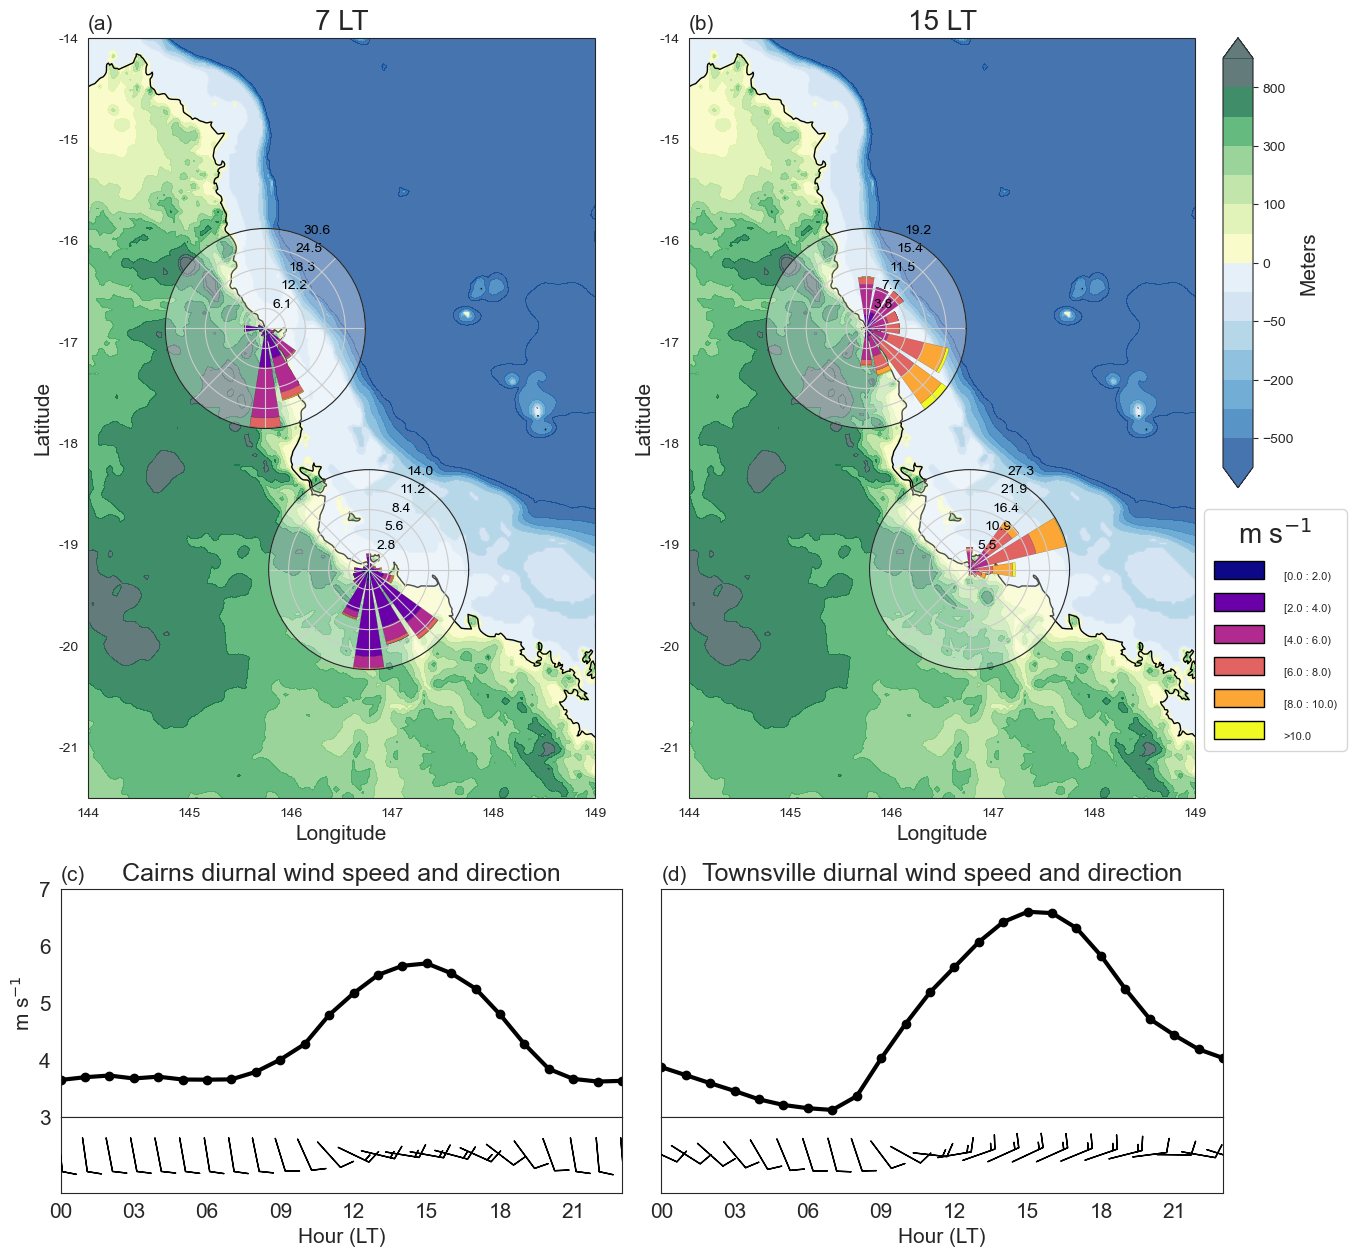

In [30]:
sns.set_style('white')
plot_diurnal_cycles(7,15,True,True,cairns_wd.values,towns_wd.values,cairns_ws.values,towns_ws.values,)


In [13]:
# Open and regrid ETOPO2V2 dataset
NOAA_ETOPO2V2_ds = xr.open_dataset('/home/563/ac9768/GBR/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
NOAA_ETOPO2V2_ds_slice = NOAA_ETOPO2V2_ds.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(NOAA_ETOPO2V2_ds_slice['x'].data), max(NOAA_ETOPO2V2_ds_slice['x'].data), len(NOAA_ETOPO2V2_ds_slice['x'].data))
lat = np.linspace(min(NOAA_ETOPO2V2_ds_slice['y'].data), max(NOAA_ETOPO2V2_ds_slice['y'].data), len(NOAA_ETOPO2V2_ds_slice['y'].data))
lon, lat = np.meshgrid(lon, lat)
topo = NOAA_ETOPO2V2_ds_slice['z'].data

In [157]:
cairns_15LT_wd = cairns_wd_mask.sel(time=cairns_wd_mask.time.dt.hour.isin(15))
cairns_15LT_ws = cairns_ws_masked.sel(time=cairns_ws_masked.time.dt.hour.isin(15))
towns_15LT_wd = towns_wd_mask.sel(time=towns_wd_mask.time.dt.hour.isin(15))
towns_15LT_ws = towns_ws_masked.sel(time=towns_ws_masked.time.dt.hour.isin(15))
#
# ds_towns_wd = jfma_data["wdir"].sel(station=30)* units("degrees")
# ds_towns_ws = jfma_data["wspd"].sel(station=30)* (1000/(60*60)) *  units("m/s")

In [ ]:
sns.set_style('white')

def plot(hour):
    cairns_15LT_wd = cairns_wd_mask.sel(time=cairns_wd_mask.time.dt.hour.isin(hour))
    cairns_15LT_ws = cairns_ws_masked.sel(time=cairns_ws_masked.time.dt.hour.isin(hour))
    towns_15LT_wd = towns_wd_mask.sel(time=towns_wd_mask.time.dt.hour.isin(hour))
    towns_15LT_ws = towns_ws_masked.sel(time=towns_ws_masked.time.dt.hour.isin(hour))

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(18, 9))
    main_ax = fig.add_subplot(1, 1, 1, projection=proj)
    minlon, maxlon, minlat, maxlat = (144, 149, -21.5, -14)
    main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
    main_ax.coastlines()

    color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fcb9','#d9f0a3','#addd8e',
            '#78c679','#31a354','#006837','darkslategrey','#d7ccca']
    levels = [-800, -500, -300, -200, -100, -50, -25, 0, 50, 100, 200, 300, 500, 800, 1000]
    cs = main_ax.contourf(lon,lat,topo,levels=levels,extend="both",colors=color,alpha=0.75)
    # cb = plt.colorbar(cs,fraction=0.05,ax=main_ax,pad=0.03)
    cbar_ax = fig.add_axes([0.67, 0.45, 0.02, 0.4])  # [left, bottom, width, height]
    cb = fig.colorbar(cs, cax=cbar_ax)
    # cb = plt.colorbar(cs,aspect=20,ax=main_ax,pad=0.04)

    # Coordinates of the station we were measuring windspeed
    towns_lon, towns_lat = (146.77,-19.25)
    cairns_lon, cairns_lat = (145.75,-16.87)

    size = 2
    # Inset axes with a fixed size
    wrax_towns = inset_axes(
        main_ax,
        width=size,  # size in inches
        height=size,  # size in inches
        loc="center",  # center bbox at given position
        bbox_to_anchor=(towns_lon, towns_lat),  # position of the axe
        bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,  # specify the class of the axe
    )
    wrax_cairns = inset_axes(
        main_ax,
        width=size,  # size in inches
        height=size,  # size in inches
        loc="center",  # center bbox at given position
        bbox_to_anchor=(cairns_lon, cairns_lat),  # position of the axe
        bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,  # specify the class of the axe
    )

    # set transparency of wind rose figure
    wrax_cairns.patch.set_alpha(0.3)
    wrax_towns.patch.set_alpha(0.3)

    # # create bar plots
    barT = wrax_towns.bar(towns_15LT_wd, towns_15LT_ws,normed=True,bins=[0,2,4,6,8,10],cmap=cm.plasma,ec='black',lw=0.1)
    barC = wrax_cairns.bar(cairns_15LT_wd, cairns_15LT_ws,normed=True,bins=[0,2,4,6,8,10],cmap=cm.plasma,ec='black',lw=0.1)
    wrax_cairns.set_legend(
        title="m s$^{-1}$",
        bbox_to_anchor=(2.2, -1.6),fontsize=18,title_fontsize=20) #(2.2,-1.2)) # #bbox_to_anchor=(4, 0.65, 1, 1)) #

    for ax in [wrax_towns, wrax_cairns]:
        ax.tick_params(colors='black',labelbottom=False)#labelleft=False

    # other plot details
    cb.set_label("Meters",fontsize=15)
    main_ax.set_title(str(hour)+" LT",fontsize=20,)
    main_ax.set_xticks([144,145,146,147,148,149])
    main_ax.set_xticklabels([144,145,146,147,148,149])
    main_ax.set_yticks([-21,-20,-19,-18,-17,-16,-15,-14])
    main_ax.set_yticklabels([-21,-20,-19,-18,-17,-16,-15,-14])
    main_ax.set_xlabel("Longitude",fontsize=15)
    main_ax.set_ylabel("Latitude",fontsize=15)
    # fig.savefig('/home/563/ac9768/GBR/plots/station_wind_roses_15LT.png', bbox_inches='tight', dpi=400)
    return main_ax

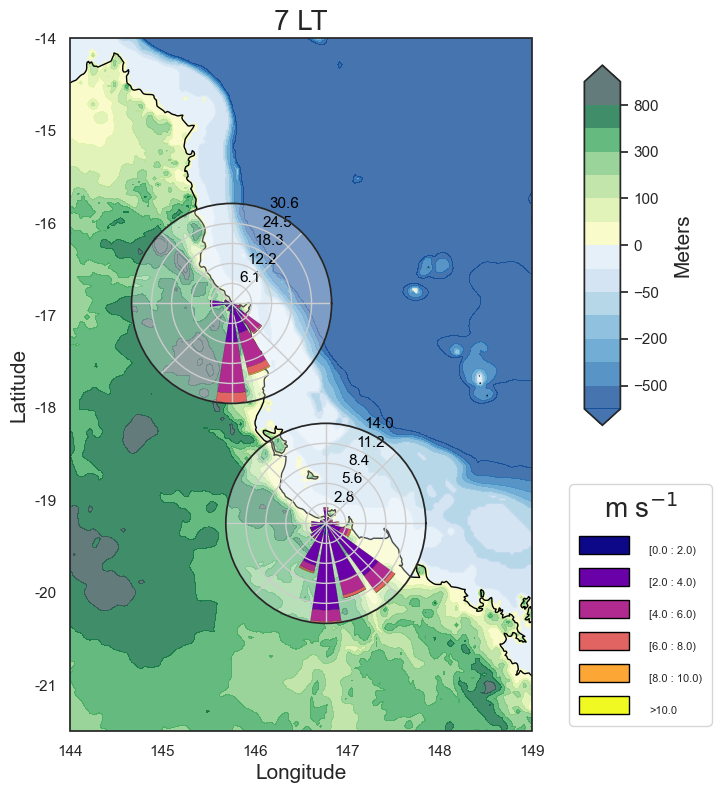

In [30]:
morning = plot(7)

In [6]:
# open netcdf files created in BA_variable-to-netcdf notebook
# mean over radar domain
barra_towns = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
# values over study domain longitude
# barra_towns_sfc = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_sfc_winds_townsville.nc", engine="h5netcdf",chunks="auto")
# barra_cairns_sfc = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_sfc_winds_cairns.nc", engine="h5netcdf",chunks="auto")
# barra_willis_sfc = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_sfc_winds_willis.nc", engine="h5netcdf",chunks="auto")
# # barra surface winds for townsville and cairns station coordinates
barra_station_towns_sfc = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_sfc-winds-station_towns.nc", engine="h5netcdf",chunks="auto")
barra_station_cairns_sfc = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_sfc-winds-station_cairns.nc", engine="h5netcdf",chunks="auto")

# BARRA-R2

In [2]:
def get_file_paths(directory,fn1,fn2): # for all barra-2 years available (1979-2023)
    """
    Returns a list of all file paths within a directory.
    
    Args:
    - directory (str): The directory path.
    
    Returns:
    - file_paths (list): List of file paths within the directory.
    """
    file_paths = []
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        # Iterate through files
        for file in files:
            # Construct the file path
            file_path = os.path.join(root, file)
            # Append the file path to the list
            file_paths.append(file_path)
    file_paths.sort()
    months_cbs = []
    for i in range(len(file_paths)):
        if file_paths[i][fn1:fn2] in ["01", "02", "03", "04"]:
            months_cbs.append(file_paths[i])
        else:
            pass
    return months_cbs
ua850 = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ua850/v20231001/",167,169) # in m/s
va850 = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/va850/v20231001/",167,169) # in m/s
uasfc = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/uasmean/v20231001/",171,173)
vasfc = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/vasmean/v20231001/",171,173)

In [3]:
def open_and_calc_mean(file_path,variable):
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        towns = ds[variable].sel(lat=-19.2483,lon=146.7661,method='nearest')
        cairns = ds[variable].sel(lat=-16.9,lon=145.7,method='nearest')        # adjusting lat lon so that is a land point          
        return (towns*units("m/s")).compute(), (cairns*units("m/s")).compute() 
uuT,uuC = open_and_calc_mean(uasfc,"uasmean")
vvT,vvC = open_and_calc_mean(vasfc,"vasmean")

In [4]:
towns_wind_dir = metpy.calc.wind_direction(uuT,vvT,convention='from')
towns_wind_speed = metpy.calc.wind_speed(uuT,vvT)
cairns_wind_dir = metpy.calc.wind_direction(uuC,vvC,convention='from')
cairns_wind_speed = metpy.calc.wind_speed(uuC,vvC)

In [7]:
cairns_wind_dir

Magnitude,[110.25094054855307 111.87218867148815 116.11073667269352 ... 217.50635780298472 182.00955381302114 133.6255378118996]
Units,degree


In [5]:
def calc_regimes(file_path,variable):#.sel(time=slice('2022-01-01T00:00:00.000000000','2022-04-30T23:00:00.000000000'))
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto").sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000')) as ds:
        towns = ds[variable].sel(lat=slice(-20.768799,-18.0708),lon=slice(145.12054,147.9812)).mean(dim=["lat","lon"])
        cairns = ds[variable].sel(lat=slice(-18.165955,-15.468018),lon=slice(144.27374,147.09222)).mean(dim=["lat","lon"])                  
        # willis = ds[variable].sel(lat=slice(-17.636353,-14.938416),lon=slice(148.55927,151.36993)).mean(dim=["lat","lon"])
        return (towns*units("m/s")).compute(),(cairns*units("m/s")).compute()#,(willis*units("m/s")).compute() 
uT,uC = calc_regimes(ua850,"ua850")
vT,vC = calc_regimes(va850,"va850")

In [56]:
towns_wind_dir_850 = metpy.calc.wind_direction(uT,vT,convention='from')
towns_wind_speed_850 = metpy.calc.wind_speed(uT,vT)
cairns_wind_dir_850 = metpy.calc.wind_direction(uC,vC,convention='from')
cairns_wind_speed_850 = metpy.calc.wind_speed(uC,vC)

# Regimes for stations

In [2]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
# print('Mean Cairns wind direction: ',calc_mean_wdir(wdir_maskC))

In [3]:
# select regime
def regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None,wind_direction=None):
    winds = barra_site.wind_dir.compute()
    if ne==True:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds==True:
        winds_dir = winds
    else:
        pass
    # now that the regime composite times have been defined, calculate the diurnal mean of variable in question 
    regime = variable_ds.sel(time=winds_dir.time.values)
    if wind_direction == True:
        group_values = regime.groupby(regime.time.dt.hour)
        mean_values = []
        for hour in np.arange(0,24,1):
            calc = calc_mean_wdir(group_values[hour])
            mean_values.append(calc)
    else:
        mean_values = regime.groupby(regime.time.dt.hour).mean(dim='time')
    # shift from utc to aest
    aest = np.roll(mean_values,shift=10,axis=0)
    # for plotting, double array to show 48 hours
    double = np.concatenate([aest,aest]) 
    return aest

In [ ]:
# from above function calc regime mean for variable: regime(barra_site,deg1,deg2,variable_ds,ne=None,all_winds=None)
# sfc_ne_station = regime(barra_cairns,0,90,barra_station_cairns_sfc.wind_dir,ne=True,all_winds=False,wind_direction=True)
# sfc_se_station = regime(barra_cairns,90,180,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
# sfc_sw_station = regime(barra_cairns,180,270,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
# sfc_nw_station = regime(barra_cairns,270,360,barra_station_cairns_sfc.wind_dir,ne=False,all_winds=False,wind_direction=True)
sfc_clim = regime(barra_towns,270,360,barra_station_towns_sfc.wind_dir,ne=False,all_winds=True,wind_direction=True)
# sfc_ne_speed = regime(barra_cairns,0,90,barra_station_cairns_sfc.wind_speed,ne=True,all_winds=False,wind_direction=False)
# sfc_se_speed = regime(barra_cairns,90,180,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
# sfc_sw_speed = regime(barra_cairns,180,270,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
# sfc_nw_speed = regime(barra_cairns,270,360,barra_station_cairns_sfc.wind_speed,ne=False,all_winds=False,wind_direction=False)
sfc_clim_speed = regime(barra_towns,270,360,barra_station_towns_sfc.wind_speed,ne=False,all_winds=True,wind_direction=False)

# Station data

In [7]:
# Weather station - Cairns, file path
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")
bmid_cairns = station_ds.bmid[21]     # BOM ID: 031011
# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
towns_wdir = station_ds.wdir.sel(station=30) * units("degrees")
towns_wspd = (station_ds.wspd.sel(station=30) * (1000/(60*60))) *  units("m/s")

In [8]:
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(1990,2022,1)#(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
wdirT = JFMA_data(towns_wdir)
wspdT = JFMA_data(towns_wspd)

In [9]:
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)
wdir_maskT,wspd_maskT = wind_masks(wdirT,wspdT)

In [11]:
def surface_winds_station_reanalysis(ds_barra,ds_obs,ds_barra_850,wdir1,wdir2,long_LST,ne=None,wind_dir=None):
    # Assuming true and predicted values, respectively
    barra = ds_barra.sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000'))
    true = ds_obs.sel(time=barra.time.values)
    true_data_array_without_nan = true.dropna(dim='time')
    pred = barra.sel(time=true_data_array_without_nan.time.values)

    # select data based on 850 hPa regimes
    winds = ds_barra_850.compute()
    if ne==True:
        wind = winds[(winds>=wdir1)&(winds<=wdir2)]
    else:
        wind = winds[(winds>wdir1)&(winds<=wdir2)]
    # select wind time values
    wind_times = wind.time.values
    wind_times.sort() 
    true_regime = true_data_array_without_nan.sel(time=wind_times,method="nearest").drop_duplicates(dim="time")
    pred_regime = pred.sel(time=wind_times,method="nearest").drop_duplicates(dim="time")
    # change from UTC to LST
    true_LST = UTC_to_LST(true_regime,long_LST,'Australia/Sydney',"%Y-%m-%dT%H:%M")
    true_LST_array = xr.DataArray(true_LST.values,dims=('time'), 
                                  coords={'time': true_LST.time}).drop_duplicates(dim="time")
    pred_LST = UTC_to_LST(pred_regime,long_LST,'Australia/Sydney',"%Y-%m-%dT%H:%M")
    pred_LST_array = xr.DataArray(pred_LST.values,dims=('time'), 
                                  coords={'time': pred_LST.time}).drop_duplicates(dim="time")
    print('obs length',len(true_LST_array))
    print('barra length',len(pred_LST_array))
    # # Calculate Mean Squared Error (MSE)
    if wind_dir==True:
        # account for circular nature of the data
        true_hourly = []
        pred_hourly = []
        errors = []
        for hour in np.arange(0,24,1):
            mean_pred = calc_mean_wdir(pred_LST_array.groupby(pred_LST_array.time.dt.hour)[hour])
            pred_hourly.append(mean_pred)
            mean_true = calc_mean_wdir(true_LST_array.groupby(true_LST_array.time.dt.hour)[hour])
            true_hourly.append(mean_true)
            # Compute circular difference
            radian_pred = np.deg2rad(pred_LST_array.groupby(pred_LST_array.time.dt.hour)[hour])
            radian_true = np.deg2rad(true_LST_array.groupby(true_LST_array.time.dt.hour)[hour])
            diff_rad = np.arctan2(np.sin(radian_true - radian_pred), np.cos(radian_true - radian_pred))
            # Convert back to degrees
            diff_deg = np.degrees(diff_rad)
            errors.append(np.mean(diff_deg))
        # Calculate mean squared error
        errors = np.array(errors)
        mse = np.mean(errors ** 2)
    else:
        # groupby hour
        true_hourly = true_LST_array.groupby(true_LST_array.time.dt.hour).mean()
        print('wind speeds LST max obs:',true_LST_array.groupby(true_LST_array.time.dt.hour).mean())
        pred_hourly = pred_LST_array.groupby(pred_LST_array.time.dt.hour).mean()
        print('wind speeds LST max barra:',pred_LST_array.groupby(pred_LST_array.time.dt.hour).mean())
        mse = mean_squared_error(true_hourly,pred_hourly)
    # # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    return true_hourly,pred_hourly,rmse

In [87]:
# rmse of total
def rmse(ds_barra,ds_obs,wind_dir=None):
    # Assuming y_true and y_pred are your true and predicted values, respectively
    barra = ds_barra.sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000'))
    true = ds_obs.sel(time=barra.time.values)
    data_array_without_nan = true.dropna(dim='time').drop_duplicates(dim="time")
    pred = barra.sel(time=data_array_without_nan.time.values).drop_duplicates(dim="time")
    # Calculate Mean Squared Error (MSE)
    if wind_dir==True:
        # account for circular nature of the data
        radian_pred = np.deg2rad(pred)
        radian_true = np.deg2rad(data_array_without_nan)
        # Compute circular difference
        diff_rad = np.arctan2(np.sin(radian_true - radian_pred), np.cos(radian_true - radian_pred))
        # Convert back to degrees
        diff_deg = np.degrees(diff_rad)
        # Calculate mean squared error
        mse = np.mean(diff_deg ** 2)
    else:
        mse = mean_squared_error(data_array_without_nan,pred)
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    return rmse
rmse(towns_wind_speed,wspd_maskT,wind_dir=False)
rmse(cairns_wind_speed,wspd_maskC,wind_dir=False)
# rmse(towns_wind_dir,wdir_maskT,wind_dir=True)
# rmse(cairns_wind_dir,wdir_maskC,wind_dir=True)

2.4652369997496093

In [95]:
# percentage of times that BARRA-2 is within 45 degrees of obs
def angle_between_barra_obs(barra, obs):
    dot = np.cos(barra)*np.cos(obs) + np.sin(barra)*np.sin(obs)
    angle = np.arccos(dot)
    return angle <= np.pi/4
    
barra = towns_wind_dir.sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000'))
true = wdir_maskT.sel(time=barra.time.values)

data_array_without_nan = true.dropna(dim='time')
pred = barra.sel(time=data_array_without_nan.time.values)
result = angle_between_barra_obs(pred, data_array_without_nan)[angle_between_barra_obs(pred, data_array_without_nan)==True]
len(result)/len(pred)*100

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/pint/numpy_func.py:303: RuntimeWarning: invalid value encountered in arccos
  result_magnitude = func(*stripped_args, **stripped_kwargs)


85.34342384814603

In [10]:
import datetime
import pytz
from datetime import datetime, timedelta
# convert datasets to LST
def UTC_to_LST(ds,longitude,timezone,output_string_format):
    # Convert time to pandas datetime objects
    time_values = pd.to_datetime(ds['time'].values,unit='ns')
    
    # Convert nanoseconds to datetime objects in UTC
    time_objects_utc = pd.to_datetime(time_values, unit='ns')
    
    # Define the time zone for the location
    local_timezone = pytz.timezone(timezone)
    
    # Convert UTC datetime objects to the local time zone
    time_objects_local = time_objects_utc.tz_localize('UTC').tz_convert(local_timezone)
    
    # Calculate the offset from UTC based on the longitude
    # 4 minutes per degree of longitude from the prime meridian
    longitude_offset = timedelta(minutes=(longitude / 360) * 60)
    
    # Adjust the time to local solar time based on the longitude offset
    time_objects_solar = time_objects_local - longitude_offset
    
    # Format datetime objects as strings or as datetime 64
    # time_strings_solar = time_objects_solar.strftime(output_string_format)
    time_strings_solar = pd.to_datetime(time_objects_solar.values,unit='ns')
    ds["time"] = time_strings_solar
    return ds

In [12]:
def plot_diurnal_cycles(obs_surface_wind_dir,barra_surface_wind_dir,obs_surface_wind_speed,barra_surface_wind_speed,title,rmse_speed,rmse_dir,sample_size,color_obs,color_barra):
    fig,ax = plt.subplots(1, figsize=[10,7])
    fig.patch.set_facecolor('white')
    sns.set_theme(style="darkgrid")
    # fig.suptitle('Cairns Station vs BARRA-2',fontsize=20)
    fig.tight_layout()
    ax.plot(np.arange(0,24,1),np.roll(obs_surface_wind_speed,shift=10),label='Station',color=color_obs,linewidth=3,marker="o")
    ax.plot(np.arange(0,24,1),np.roll(barra_surface_wind_speed,shift=10),label='BARRA-2',color=color_barra,linewidth=3,marker="o")
    ax.set_title(title,fontsize=25,pad=15)
    ax.set_xlabel('Hour (LST)',fontsize=20)
    ax.set_ylabel('Wind Speed (m/s)',fontsize=20)
    ax.set_xlim(0,23)
    ax.set_ylim(-3,7)
    ax.set_yticks([0,1,2,3,4,5,6,7])
    ax.annotate(xy=(0.4,6.3),text=sample_size,fontsize=20)
    ax.annotate(xy=(0.4,5.3),text=rmse_speed,fontsize=15)
    ax.annotate(xy=(0.4,4.3),text=rmse_dir,fontsize=15)
    ax.set_xticks(np.arange(0,23,3))
    ax.set_xticklabels(["00","03","06","09","12","15","18","21"],fontsize=15)
    ax.set_yticklabels(np.arange(0,8,1),fontsize=15)
    # ax.grid(axis="x")
    # ax.grid(axis="y")
    plt.legend(loc='upper right',fontsize=17.5)
    # station barbs
    wind_direction_degrees = np.array(np.roll(obs_surface_wind_dir,shift=10) + 180) # 180 is added so that the direction plotted for barbs is the direction "from"
    wind_direction_radians = np.radians(90 - wind_direction_degrees)
    ax.barbs(range(len(wind_direction_degrees)), [-1] * len(wind_direction_degrees), np.roll(obs_surface_wind_speed,shift=10) * np.cos(wind_direction_radians), 
              np.roll(obs_surface_wind_speed,shift=10) * np.sin(wind_direction_radians),
              barb_increments=dict(half=2, full=4, flag=20), length=7,pivot='middle',flip_barb=True,color=color_obs)
    # barra barbs
    wind_direction_degrees_barra = np.array(np.roll(barra_surface_wind_dir,shift=10) + 180)
    wind_direction_radians_barra = np.radians(90 - wind_direction_degrees_barra)
    ax.barbs(range(len(wind_direction_degrees_barra)), [-2] * len(wind_direction_degrees_barra), np.roll(barra_surface_wind_speed,shift=10) * np.cos(wind_direction_radians_barra),
            np.roll(barra_surface_wind_speed,shift=10) * np.sin(wind_direction_radians_barra),
            barb_increments=dict(half=2, full=4, flag=20), length=7,pivot='middle',flip_barb=True,color=color_barra)
    return

In [13]:
# convert all datasets to LST, then drop time duplicates as you create an xarray dataarray
#towns
towns_wspdmaskLST = UTC_to_LST(wspd_maskT,146.55,'Australia/Sydney',"%Y-%m-%dT%H:%M")
towns_wspdmask_LST = xr.DataArray(towns_wspdmaskLST.values,dims=('time'), coords={'time': towns_wspdmaskLST.time}).drop_duplicates(dim="time")
towns_wind_speedLST = UTC_to_LST(towns_wind_speed,146.55,'Australia/Sydney',"%Y-%m-%dT%H:%M")
towns_wind_speed_LST = xr.DataArray(towns_wind_speedLST.values,dims=('time'), coords={'time': towns_wind_speedLST.time}).drop_duplicates(dim="time")
towns_wdirmaskLST = UTC_to_LST(wdir_maskT,146.55,'Australia/Sydney',"%Y-%m-%dT%H:%M")
towns_wdirmask_LST = xr.DataArray(towns_wdirmaskLST.values,dims=('time'), coords={'time': towns_wdirmaskLST.time}).drop_duplicates(dim="time")
towns_wind_dir_850LST = UTC_to_LST(towns_wind_dir_850,146.55,'Australia/Sydney',"%Y-%m-%dT%H:%M")
towns_wind_dir_850_LST = xr.DataArray(towns_wind_dir_850LST.values,dims=('time'), coords={'time': towns_wind_dir_850LST.time}).drop_duplicates(dim="time")
towns_wind_dirLST = UTC_to_LST(towns_wind_dir,146.55,'Australia/Sydney',"%Y-%m-%dT%H:%M")
towns_wind_dir_LST = xr.DataArray(towns_wind_dirLST.values,dims=('time'), coords={'time': towns_wind_dirLST.time}).drop_duplicates(dim="time")
# cairns
cairns_wspdmaskLST = UTC_to_LST(wspd_maskC,145.6,'Australia/Sydney',"%Y-%m-%dT%H:%M")
cairns_wspdmask_LST = xr.DataArray(cairns_wspdmaskLST.values,dims=('time'), coords={'time': cairns_wspdmaskLST.time}).drop_duplicates(dim="time")
cairns_wdirmaskLST = UTC_to_LST(wdir_maskC,145.6,'Australia/Sydney',"%Y-%m-%dT%H:%M")
cairns_wdirmask_LST = xr.DataArray(cairns_wdirmaskLST.values,dims=('time'), coords={'time': cairns_wdirmaskLST.time}).drop_duplicates(dim="time")
cairns_wind_dir_850LST = UTC_to_LST(cairns_wind_dir_850,145.6,'Australia/Sydney',"%Y-%m-%dT%H:%M")
cairns_wind_dir_850_LST = xr.DataArray(cairns_wind_dir_850LST.values,dims=('time'), coords={'time': cairns_wind_dir_850LST.time}).drop_duplicates(dim="time")
cairns_wind_dirLST = UTC_to_LST(cairns_wind_dir,145.6,'Australia/Sydney',"%Y-%m-%dT%H:%M")
cairns_wind_dir_LST = xr.DataArray(cairns_wind_dirLST.values,dims=('time'), coords={'time': cairns_wind_dirLST.time}).drop_duplicates(dim="time")
cairns_wind_speedLST = UTC_to_LST(cairns_wind_speed,145.6,'Australia/Sydney',"%Y-%m-%dT%H:%M")
cairns_wind_speed_LST = xr.DataArray(cairns_wind_speedLST.values,dims=('time'), coords={'time': cairns_wind_speedLST.time}).drop_duplicates(dim="time")

NameError: name 'towns_wind_speed' is not defined

In [81]:
towns_wind_speed_hourly_obs,towns_wind_speed_hourly_barra,rmse_wind_speed = surface_winds_station_reanalysis(towns_wind_speed,wspd_maskT,towns_wind_dir_850,
                0*units("degrees"),360*units("degrees"),146.55,ne=True,wind_dir=False)
towns_wind_dir_hourly_obs,towns_wind_dir_hourly_barra,rmse_wind_dir = surface_winds_station_reanalysis(towns_wind_dir,wdir_maskT,towns_wind_dir_850,
                0*units("degrees"),360*units("degrees"),146.55,ne=True,wind_dir=True)

obs length 64487
barra length 64487
wind speeds LST max obs: <xarray.DataArray (hour: 24)> Size: 96B
array([5.168106 , 5.6373267, 6.0748205, 6.4237304, 6.6321783, 6.6200027,
       6.4142137, 5.9131284, 5.1712413, 4.68946  , 4.4157505, 4.166892 ,
       4.001463 , 3.8633807, 3.7339246, 3.5906634, 3.4100769, 3.303549 ,
       3.1820443, 3.1552935, 3.072611 , 3.2965522, 3.9905608, 4.5987663],
      dtype=float32)
Coordinates:
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
wind speeds LST max barra: <xarray.DataArray (hour: 24)> Size: 192B
array([4.36364231, 4.83442973, 5.29621562, 5.57027144, 5.80518191,
       5.87704791, 5.75649065, 5.42558261, 4.87536722, 4.27356943,
       4.14455332, 4.03802041, 3.89692653, 3.75258269, 3.58565922,
       3.39306758, 3.23014744, 3.11054816, 3.03796146, 2.98251023,
       2.96364433, 3.10473213, 3.53263857, 3.93334131])
Coordinates:
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
obs len

In [82]:
cairns_wind_speed_hourly_obs,cairns_wind_speed_hourly_barra,cairnsrmse_wind_speed = surface_winds_station_reanalysis(cairns_wind_speed,wspd_maskC,cairns_wind_dir_850,
                0*units("degrees"),360*units("degrees"),145.6,ne=True,wind_dir=False)
cairns_wind_dir_hourly_obs,cairns_wind_dir_hourly_barra,cairnsrmse_wind_dir = surface_winds_station_reanalysis(cairns_wind_dir,wdir_maskT,cairns_wind_dir_850,
                0*units("degrees"),360*units("degrees"),145.6,ne=True,wind_dir=True)

obs length 77807
barra length 77807
wind speeds LST max obs: <xarray.DataArray (hour: 24)> Size: 96B
array([4.6860666, 5.173953 , 5.509304 , 5.665662 , 5.733185 , 5.614998 ,
       5.32452  , 4.915284 , 4.251507 , 3.7751515, 3.6073172, 3.6415246,
       3.6403837, 3.6666574, 3.71103  , 3.753609 , 3.7444446, 3.7022307,
       3.6732993, 3.6757147, 3.6388535, 3.7654257, 3.9455874, 4.2143645],
      dtype=float32)
Coordinates:
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
wind speeds LST max barra: <xarray.DataArray (hour: 24)> Size: 192B
array([2.95742412, 3.38754177, 3.7042855 , 3.83880062, 3.90053426,
       3.73789009, 3.43734563, 2.95773324, 2.38681782, 1.93286403,
       1.71190032, 1.56357136, 1.50476108, 1.48166117, 1.47474284,
       1.51006386, 1.53301441, 1.54720176, 1.57898849, 1.60811956,
       1.62660663, 1.58220948, 1.92201584, 2.46934428])
Coordinates:
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
obs len

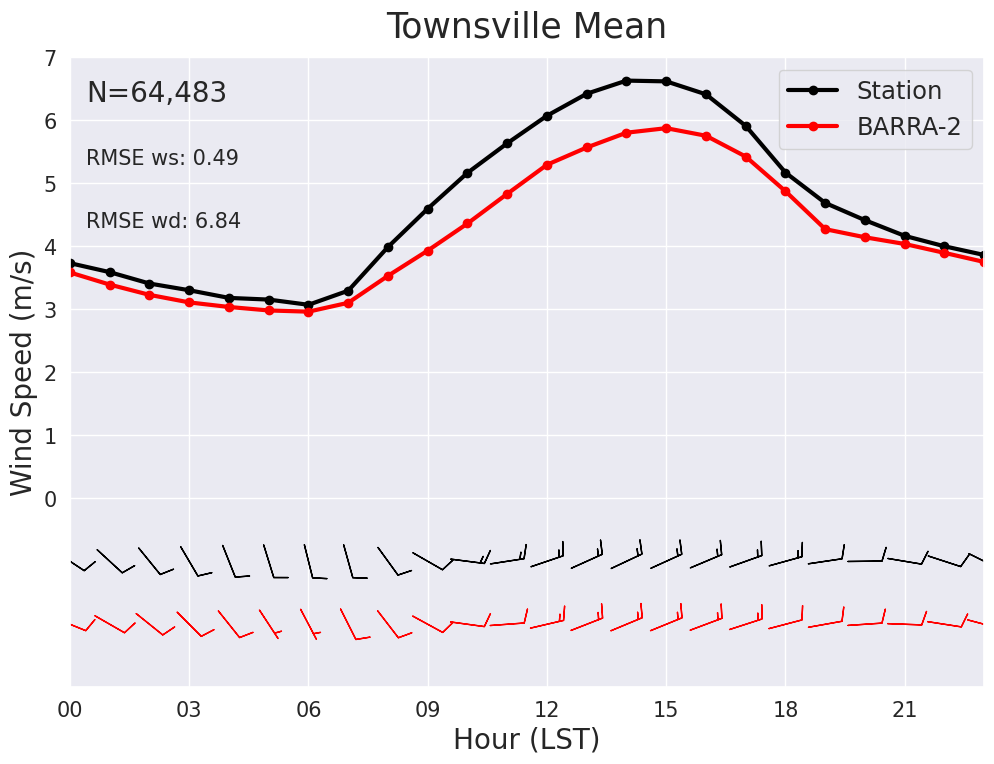

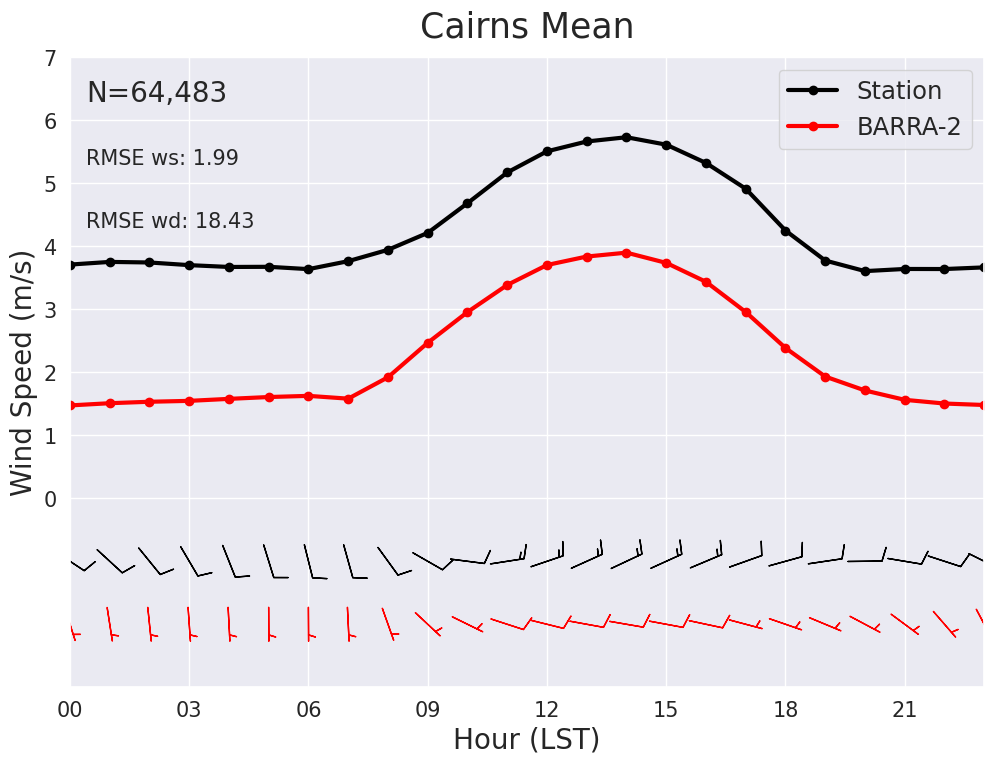

In [83]:
sns.set_theme(style="darkgrid")
plot_diurnal_cycles(towns_wind_dir_hourly_obs,towns_wind_dir_hourly_barra,towns_wind_speed_hourly_obs,towns_wind_speed_hourly_barra,"Townsville Mean",
                    "RMSE ws: " "{:.2f}".format(rmse_wind_speed),"RMSE wd: " "{:.2f}".format(rmse_wind_dir),"N=64,483","black","red")
plot_diurnal_cycles(cairns_wind_dir_hourly_obs,cairns_wind_dir_hourly_barra,cairns_wind_speed_hourly_obs,cairns_wind_speed_hourly_barra,"Cairns Mean",
                    "RMSE ws: " "{:.2f}".format(cairnsrmse_wind_speed),"RMSE wd: " "{:.2f}".format(cairnsrmse_wind_dir),"N=64,483","black","red")

[264.41765975 258.22256889 268.88228121 262.79562643 254.04795727
 240.7851779  242.91188025 261.42346875 270.6268208  294.90409983
 335.29991496 358.4532727    3.55599136   9.63577048   9.6387843
   7.93703072   7.11564924   3.33117461 344.18814941 326.51686542
 305.97706591 285.44059953 284.25968714 268.07727511]


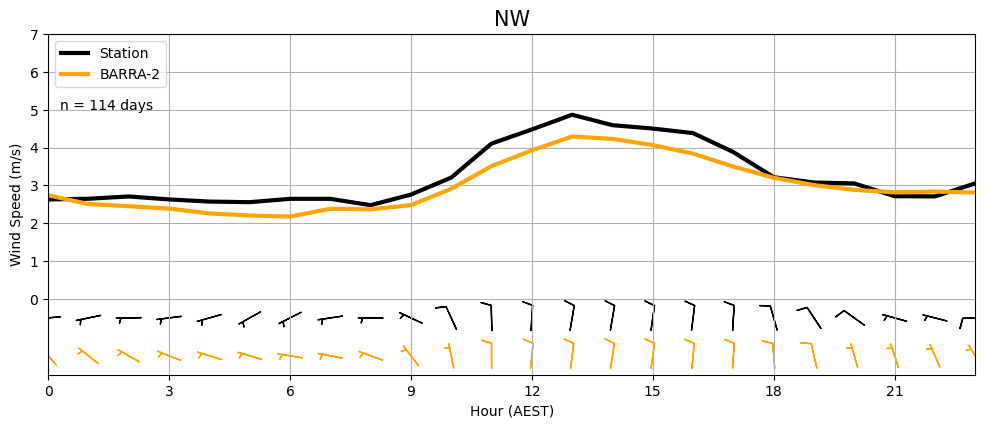

In [79]:
# make sure correct barra site for regimes is selected here:
# barra_wdir = barra_cairns.wind_dir.compute()
# # 2. Classify wind regimes and their time periods
# barra_wdir_NE = barra_wdir[(barra_wdir>=0)&(barra_wdir<=90)]
# barra_wdir_SE = barra_wdir[(barra_wdir>90)&(barra_wdir<=180)]
# barra_wdir_SW = barra_wdir[(barra_wdir>180)&(barra_wdir<=270)]
# barra_wdir_NW = barra_wdir[(barra_wdir>270)&(barra_wdir<=360)]

def calc_mean_and_plot(station_site_wdir,station_site_wspd,regime,barra_sfc_station_wdir,barra_sfc_station_wspd,title,sample_size,color):
    fig,ax = plt.subplots(1, figsize=[10,6])
    fig.patch.set_facecolor('white')
    # fig.suptitle('Cairns Station vs BARRA-2',fontsize=20)
    fig.tight_layout()
    
    # define station and barra wind direction and speed arrays for composites
    # 2. Station data set to only look at the hourly values
    station_hourly_wdir = station_site_wdir.isel(time=station_site_wdir['time.minute'] == 0)
    station_hourly_wspd = station_site_wspd.isel(time=station_site_wspd['time.minute'] == 0)
    # 3. Select station dataset times to align with barra wind regimes
    station_wdir = station_hourly_wdir.sel(time=regime.time.values,method='nearest')
    station_wspd = station_hourly_wspd.sel(time=regime.time.values,method='nearest')
    
    # 4. Group station datasets by hour 
    wdir = station_wdir.groupby(station_wdir.time.dt.hour)
    wdspd = station_wspd.groupby(station_wspd.time.dt.hour).mean(dim="time")
    # 5. Calculate circ mean for wind direction, regular mean for speed above
    deg = []
    for hour in np.arange(0,24,1):
        wdir_deg = calc_mean_wdir(wdir[hour])
        deg.append(wdir_deg)
    # wdir_mean = np.roll(deg,shift=10,axis=0)
    # 6. Change to AEST
    aest_dir = np.roll(deg,shift=10)
    aest_speed = np.roll(wdspd,shift=10,axis=0)       
    # plot
    ax.plot(np.arange(0,24,1),aest_speed,label='Station',color="black",linewidth=3)
    ax.plot(np.arange(0,24,1),barra_sfc_station_wspd,label='BARRA-2',color=color,linewidth=3)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel('Hour (AEST)')
    ax.set_ylabel('Wind Speed (m/s)')
    ax.set_xlim(0,23)
    ax.set_ylim(-2,7)
    ax.set_yticks([0,1,2,3,4,5,6,7])
    ax.annotate(xy=(0.3,5),text=sample_size)
    ax.set_xticks(np.arange(0,23,3))
    ax.grid()
    plt.legend(loc='upper left')
    # station barbs
    print(aest_dir)
    wind_direction_degrees = np.array(aest_dir + 180) # 180 is added so that the direction plotted for barbs is the direction "from"
    wind_direction_radians = np.radians(90 - wind_direction_degrees)
    ax.barbs(range(len(wind_direction_degrees)), [-0.5] * len(wind_direction_degrees), aest_speed * np.cos(wind_direction_radians), aest_speed * np.sin(wind_direction_radians),
              barb_increments=dict(half=2, full=4, flag=20), length=6,pivot='middle',flip_barb=True)
    # barra barbs
    wind_direction_degrees_barra = np.array(barra_sfc_station_wdir + 180)
    wind_direction_radians_barra = np.radians(90 - wind_direction_degrees_barra)
    ax.barbs(range(len(wind_direction_degrees_barra)), [-1.5] * len(wind_direction_degrees_barra), barra_sfc_station_wspd * np.cos(wind_direction_radians_barra), barra_sfc_station_wspd * np.sin(wind_direction_radians_barra),
              barb_increments=dict(half=2, full=4, flag=20), length=6,pivot='middle',flip_barb=True,color=color)
    return

# for station inputs, make sure the wind direction mask (removes calm conditions) and wind speed masks have been applied
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_NE,sfc_ne_station,sfc_ne_speed,'NE','n = 160 days','seagreen')
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_SE,sfc_se_station,sfc_se_speed,'SE','n = 841 days','royalblue')
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_SW,sfc_sw_station,sfc_sw_speed,'SW','n = 146 days','purple')
calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir_NW,sfc_nw_station,sfc_nw_speed,'NW','n = 114 days','orange')

# towns
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_NE,sfc_ne_station,sfc_ne_speed,'NE','n = 255 days','seagreen')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_SE,sfc_se_station,sfc_se_speed,'SE','n = 826 days','royalblue')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_SW,sfc_sw_station,sfc_sw_speed,'SW','n = 105 days','purple')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir_NW,sfc_nw_station,sfc_nw_speed,'NW','n = 75 days','orange')

# climatologies
# calc_mean_and_plot(wdir_maskC,wspd_maskC,barra_wdir,sfc_clim,sfc_clim_speed,'Cairns Climatology','n = 1262 days','red')
# calc_mean_and_plot(wdir_maskT,wspd_maskT,barra_wdir,sfc_clim,sfc_clim_speed,'Townsville Climatology','n = 1262 days','red')


# Plotting climatological means

In [ ]:
#plot diurnal cycle
fig,ax = plt.subplots(4,1, figsize=[6,6])
fig.patch.set_facecolor('white')
fig.suptitle('Cairns BoM Station',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)

# plot wind barbs
# barb_length = 5  # Adjust the barb length as needed
# ax[0].barbs(range(len(wind_direction_degrees)), [0] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
#           barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',flip_barb=True)

In [56]:
def diurnal_cycle(ds,winds=None):
    morning = [18,19,20]
    four_am = ds.sel(time=ds.time.dt.hour.isin(morning)) #18 UTC = 4am AEST
    afternoon = [4,5,6] #2-4pm
    four_pm = ds.sel(time=ds.time.dt.hour.isin(afternoon)) #6 UTC = 4pm AEST
    
    # create for loop 
    hourly = ds.groupby(ds.time.dt.hour)
    mean_hourly = []
    if winds==True:
        for hour in range(len(hourly)):
            print(len(hourly[hour]))
            values = hourly[hour].values
            mean = calc_mean_wdir(values)
            mean_hourly.append(mean) 
    else:
        for hour in range(len(hourly)):
            values = hourly[hour].dropna(dim='time').values
            mean = np.mean(values)
            mean_hourly.append(mean) 
    mean_hourly_AEST = np.roll(mean_hourly, shift=10)
    return mean_hourly_AEST, four_am, four_pm 

In [57]:
# townsville
mean_hourly_wdir_AEST_T,four_am_wdirT,four_pm_wdirT = diurnal_cycle(wind_dir_towns,winds=True)
mean_hourly_wspd_AEST_T,four_am_wspdT,four_pm_wspdT = diurnal_cycle(wind_speed_towns,winds=False)
# cairns
# mean_hourly_wdir_AEST_C,four_am_wdirC,four_pm_wdirC = diurnal_cycle(wind_dir_cairns,winds=True)
# mean_hourly_wspd_AEST_C,four_am_wspdC,four_pm_wspdC = diurnal_cycle(wind_speed_cairns,winds=False)

1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262


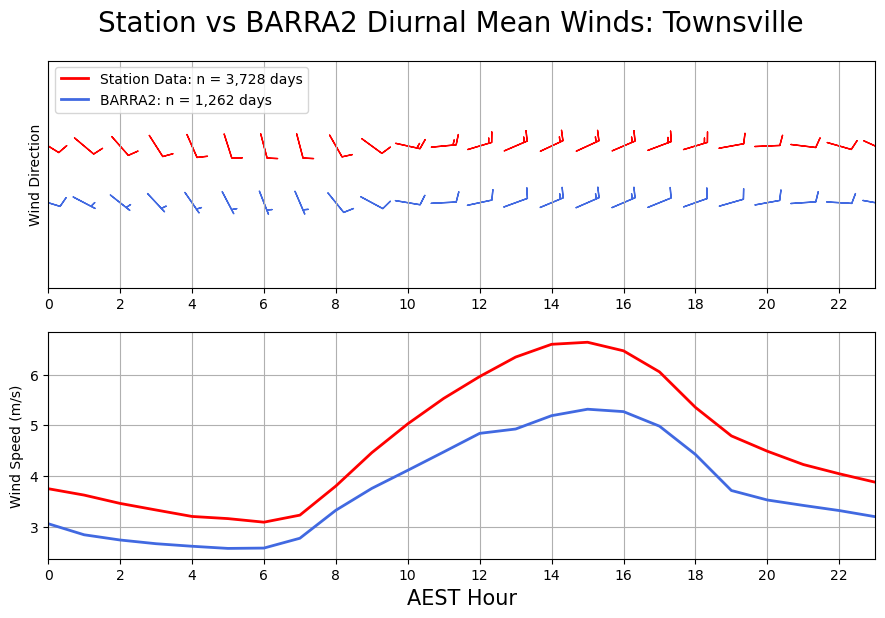

In [84]:
# plot
fig,ax = plt.subplots(2,1, figsize=[9,6])
fig.patch.set_facecolor('white')
fig.suptitle('Station vs BARRA2 Diurnal Mean Winds: Townsville',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST_T + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)
station_wind_direction_degrees = np.array(station_mean_hourly_wdir_AEST_T + 180)
station_wind_direction_radians = np.radians(90 - station_wind_direction_degrees)
station_wind_speed = np.array(station_mean_hourly_wspd_AEST_T)

# plot wind barbs
barb_length = 6  # Adjust the barb length as needed
ax[0].barbs(range(len(wind_direction_degrees)), [-0.5] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='royalblue',flip_barb=True)
ax[0].barbs(range(len(station_wind_direction_degrees)), [0.5] * len(station_wind_direction_degrees), station_wind_speed * np.cos(station_wind_direction_radians), station_wind_speed * np.sin(station_wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='red',flip_barb=True)
ax[1].plot(np.arange(0,24,1),station_mean_hourly_wspd_AEST_T,linewidth=2,color='red',label='Station Data: n = 3,728 days')
ax[1].plot(np.arange(0,24,1),mean_hourly_wspd_AEST_T,linewidth=2,color='royalblue',label='BARRA2: n = 1,262 days')
ax[0].set_ylabel('Wind Direction')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[0].set_ylim(-2,2)
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
# ax[1].set_ylim(0,7)
ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].set_xticks(np.arange(0,24,2))
ax[1].set_xticks(np.arange(0,24,2))
# ax[0].set_title('Wind Direction')
# ax[1].set_title('Wind Speed')
ax[1].set_xlabel('AEST Hour',fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(0, 2.2))
ax[0].grid(axis='both')
ax[1].grid(axis='both')
# plt.annotate('n = 3,728 days',(20,5));